Here we fit the diffuse model to most of the sky. The spectrum of each diffuse component is fixed and the following values are allowed to vary in the fit to a single energy bin running from 1-100 GeV (to preserve a good PSF).

Target values:
* X_CO for each of the 9 rings
* ics components
* Bremss fraction

Background values: 
* Isotropic template with fixed spectrum. 
* PSC tempalte with fixed norm and spectrum.


In [1]:
import Analysis
import cPickle as pickle
reload(Analysis)

#A = Analysis.Analysis(n_bins=0, prefix_bins=[1000,100000], tag='P7REP_CLEAN_V15_calore', )
A = Analysis.Analysis(tag='P7REP_CLEAN_V15_calore', )


# A.GenPointSourceTemplate(pscmap=(A.basepath + '/PSC_all_sky_3fgl.npy'))
# A.BinPhotons(outfile='binned_photons_all_sky.npy')


A.GenSquareMask(l_range=[180.,180], b_range=[-40.,40.], plane_mask=0.)
A.BinPhotons(infile='binned_photons_all_sky.npy')

# Load 2FGL 
A.AddPointSourceTemplate(fixNorm=True, pscmap=(A.basepath + '/PSC_all_sky_3fgl.npy'))

A.CalculatePixelWeights(diffuse_model='fermi_diffuse_'+A.tag+'.npy',psc_model='PSC_' + A.tag + '.npy',
                        alpha_psc=5., f_psc=0.1)

A.AddIsotropicTemplate(fixNorm=True, fixSpectrum=True) # External chi^2 used to fix normalization within uncertainties


#A.AddDMTemplate(profile='NFW', limits=[None,None], decay=False, gamma=1.26, 
#                r_s=20.0, axesratio=1, offset=(0, 0), spec_file=None,)

A.PrintTemplates()

                NAME                    LIMITS      VALUE    FIXNORM    FIXSPEC   SRCCLASS
                 PSC              [None, None]  1.000e+00       True       True        PSC
           Isotropic              [None, None]  1.000e+00       True       True        ISO


In [2]:
import multiprocessing as mp
import Tools

def AddGalpropRings(self, basedir='/data/galprop2/output/',
               tag='NSPEB_no_secondary_HI_H2', verbosity=0, multiplier=1., bremsfrac=None, E_subsample=3,
               fixSpectrum=True, nrings=9):
        """
        This method takes a base analysis prefix, along with an X_CO profile and generates the combined diffuse template,
        or components of the diffuse template.

        :param basedir: Base directory to read from
        :param tag: Tag for the galprop file.  This is the part between '_54_' and '.gz'.
        :param verbosity: 0 is quiet, >1 prints status.
        :param multiplier: Blur each map using Gaussian kernel with sigma=FWHM_PSF*multiplier/2
        :param bremsfrac: If None, brems is treated as independent.  Otherwise Brem normalization
            is linked to Pi0 normalization, scaled by a factor bremsfrac.
        :param E_subsample: Number of energy sub bins to use when integrating over each energy band.
        :para fixSpectrum: Allow the spectrum to float in each energy bin.
        """

        #---------------------------------------------------------------------------------
        # Load templates

        if verbosity>0:
            print 'Loading FITS'

        energies = pyfits.open(basedir+'/bremss_healpix_54_'+tag+'.gz')[2].data.field(0)
        comps, comps_new = {}, {}
#         # For some reason, older versions of galprop files have slightly different data structures.  This try/except
#         # will detect the right one to use. 
         
#         try:
#             comps['ics'] = pyfits.open(basedir+'/ics_isotropic_healpix_54_'+tag+'.gz')[1].data.field(0).T
#             nside_in = np.sqrt(comps['ics'].shape[1]/12)
#             comps['pi0'] = pyfits.open(basedir+'/pi0_decay_healpix_54_'+tag+'.gz')[1].data.field(0).T
#             comps['brem'] = pyfits.open(basedir+'/bremss_healpix_54_'+tag+'.gz')[1].data.field(0).T

        #except:
        def ReadFits(fname, length):
            d = pyfits.open(fname)[1].data
            return np.array([d.field(i) for i in range(length)])
        
        # Add up the HI and HII contributions into a single template since nothing there is varying.
        pi0HIHII = np.zeros((len(energies), 12*self.nside**2))
        bremHIHII = np.zeros((len(energies), 12*self.nside**2))
        
        for i_ring in range(1,nrings+1):
            print "Adding HI/HII ring", i_ring
            bremHIHII += ReadFits(basedir+'/bremss_HIR_ring_'+str(i_ring)+'_healpix_54_'+tag+'.gz', len(energies))
            bremHIHII += ReadFits(basedir+'/bremss_HII_ring_'+str(i_ring)+'_healpix_54_'+tag+'.gz', len(energies))
            pi0HIHII += ReadFits(basedir+'/pi0_decay_HIR_ring_'+str(i_ring)+'_healpix_54_'+tag+'.gz', len(energies))
            pi0HIHII += ReadFits(basedir+'/pi0_decay_HII_ring_'+str(i_ring)+'_healpix_54_'+tag+'.gz', len(energies))
        comps['pi0HIHII'] = pi0HIHII + 1.25*bremHIHII
        #comps['bremHIHII'] = bremHIHII
        comps_new['pi0HIHII'] =  np.zeros((self.n_bins, 12*self.nside**2))
        #comps_new['bremHIHII'] =  np.zeros((self.n_bins, 12*self.nside**2))
        
        
        for i_ring in range(1,nrings+1):
            print "Adding H2 ring", i_ring
            #comps['brem_H2_'+str(i_ring)]= ReadFits(basedir+'/bremss_HIR_ring_'+str(i_ring)+'_healpix_54_'+tag+'.gz', len(energies))
            brem = ReadFits(basedir+'/bremss_H2R_ring_'+str(i_ring)+'_healpix_54_'+tag+'.gz', len(energies))
            pi = ReadFits(basedir+'/pi0_decay_H2R_ring_'+str(i_ring)+'_healpix_54_'+tag+'.gz', len(energies))
            comps['pi0_H2_'+str(i_ring)] = pi + 1.25*brem
            #comps_new['brem_H2_'+str(i_ring)] = np.zeros((self.n_bins, 12*self.nside**2))
            comps_new['pi0_H2_'+str(i_ring)] =  np.zeros((self.n_bins, 12*self.nside**2))
        
        
        comps['ics'] = np.zeros((len(energies), 12*self.nside**2))
        comps_new['ics'] = np.zeros((self.n_bins, 12*self.nside**2))
        for i_ics in range(1,4):
            print "Adding ics", i_ics
            comps['ics'] += ReadFits(basedir+'/ics_isotropic_comp_'+str(i_ics)+'_healpix_54_'+tag+'.gz', len(energies))
#             comps['ics_'+str(i_ics)] = ReadFits(basedir+'/ics_isotropic_comp_'+str(i_ics)+'_healpix_54_'+tag+'.gz', len(energies))
#             comps_new['ics_'+str(i_ics)] = np.zeros((self.n_bins, 12*self.nside**2))
        
        nside_in = np.sqrt(comps['pi0HIHII'].shape[1]/12)
        
        #---------------------------------------------------------------------------------
        # Now we integrate each model over the energy bins...
        #
        # Multiprocessing for speed. There is an async callback which applies each result to
        # the arrays.  Not sure why RunAsync needs new thread pool for each component, but this
        # works and decreases memory footprint.
        def callback(result):
            idx, comp, dat = result
            comps_new[comp][idx] = dat

        def RunAsync(component):
            p = mp.Pool(mp.cpu_count())
            for i_E in range(self.n_bins):
                p.apply_async(Tools.AsyncInterpolateHealpix,
                              [comps[component], energies, self.bin_edges[i_E], self.bin_edges[i_E+1],
                               i_E, component, E_subsample, self.nside],
                              callback=callback)
            p.close()
            p.join()

        # For each component, run the async sampling/sizing.
        for key in comps:
            if verbosity>0:
                print 'Integrating and Resampling', key, 'templates...'
                sys.stdout.flush()
            RunAsync(key)


        #---------------------------------------------------------------------------------
        # Now we just need to add the templates to the active template stack
        print 'Adding Templates to stack'
        
        self.AddTemplate(name='pi0HIHII', healpixCube=comps_new['pi0HIHII'], fixSpectrum=fixSpectrum, fixNorm=False,
                           value=1., ApplyIRF=True,noPSF=True, sourceClass='GEN', limits=[None, None], multiplier=multiplier)
        #self.AddTemplate(name='bremHIHII', healpixCube=comps_new['bremHIHII'], fixSpectrum=fixSpectrum, fixNorm=False,
        #                   value=1., ApplyIRF=True,noPSF=True, sourceClass='GEN', limits=[None, None], multiplier=multiplier)

        for i_ring in range(1,nrings+1):
            self.AddTemplate(name='pi0_H2_'+str(i_ring), healpixCube=comps_new['pi0_H2_'+str(i_ring)], fixSpectrum=fixSpectrum, fixNorm=False,
                           value=1., ApplyIRF=True,noPSF=True, sourceClass='GEN', limits=[None, None], multiplier=multiplier)
            #self.AddTemplate(name='brem_H2_'+str(i_ring), healpixCube=comps_new['brem_H2_'+str(i_ring)], fixSpectrum=fixSpectrum, fixNorm=False,
            #               value=1., ApplyIRF=True,noPSF=True, sourceClass='GEN', limits=[None, None], multiplier=multiplier)
        
#         for i_ics in range(1,4):
#             self.AddTemplate(name='ics_'+str(i_ics), healpixCube=comps_new['ics_'+str(i_ics)], fixSpectrum=fixSpectrum, fixNorm=False,
#                            value=1., ApplyIRF=True,noPSF=True, sourceClass='GEN', limits=[None, None], multiplier=multiplier)
        self.AddTemplate(name='ics', healpixCube=comps_new['ics'], fixSpectrum=fixSpectrum, fixNorm=False,
                       value=1., ApplyIRF=True,noPSF=True, sourceClass='GEN', limits=[None, None], multiplier=multiplier)

AddGalpropRings(A, basedir='/data/galprop2/output/',
               tag='base', verbosity=0, multiplier=1., bremsfrac=None, E_subsample=3,
               fixSpectrum=True, nrings=9)

Adding HI/HII ring 1
Adding HI/HII ring 2
Adding HI/HII ring 3
Adding HI/HII ring 4
Adding HI/HII ring 5
Adding HI/HII ring 6
Adding HI/HII ring 7
Adding HI/HII ring 8
Adding HI/HII ring 9
Adding H2 ring 1
Adding H2 ring 2
Adding H2 ring 3
Adding H2 ring 4
Adding H2 ring 5
Adding H2 ring 6
Adding H2 ring 7
Adding H2 ring 8
Adding H2 ring 9
Adding ics 1
Adding ics 2
Adding ics 3


/home/carlson/ipython/IPython/kernel/__main__.py:53: RuntimeWarning: invalid value encountered in add
/home/carlson/anaconda/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:1568: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]
/home/carlson/anaconda/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:1568: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]
/home/carlson/anaconda/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:1568: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]
/home/carlson/anaconda/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:1568: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]
/home/carlson/anaconda/lib/python2.7/site-packages/sci

Adding Templates to stack


In [3]:

A.PrintTemplates()

                NAME                    LIMITS      VALUE    FIXNORM    FIXSPEC   SRCCLASS
            pi0HIHII              [None, None]  1.000e+00      False       True        GEN
                 PSC              [None, None]  1.000e+00       True       True        PSC
            pi0_H2_1              [None, None]  1.000e+00      False       True        GEN
                 ics              [None, None]  1.000e+00      False       True        GEN
            pi0_H2_3              [None, None]  1.000e+00      False       True        GEN
            pi0_H2_2              [None, None]  1.000e+00      False       True        GEN
            pi0_H2_5              [None, None]  1.000e+00      False       True        GEN
           Isotropic              [None, None]  1.000e+00       True       True        ISO
            pi0_H2_7              [None, None]  1.000e+00      False       True        GEN
            pi0_H2_6              [None, None]  1.000e+00      False       True        GEN

In [4]:
import GammaLikelihood as like

for key, t in A.templateList.items():
    if key not in [ 'PSC' ,'Isotropic'] :
        t.fixNorm = False
        t.fixSpectrum= True
        t.limits = [0.0,10.]
        t.value=1.
        
        
m = like.RunLikelihood(A, print_level=1, precision=None, tol=1e2, force_cpu=False, use_basinhopping=False)[0]
        
#     if key not in ['pi0HIHII', 'bremHIHII']:
#         t.fixNorm=True
#     else:
#         t.fixNorm=False
#         t.fixSpectrum=False

#A.RunLikelihood(print_level=0, tol=1e2, precision=None, minos=True)



#m = like.RunLikelihoodBinByBin(0,A, ignoreError=True, print_level=1, precision=None, tol=1e2)
# hesse = m.hesse()


Masking completed in 5.2990e-01 s
Code generation completed in 9.5010e-03 s
Using GPU mode. (Successful import of cudamat module.)

GammaLikelihood.py:247: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     pi0HIHII = +1.000000
          PSC = +1.000000
     pi0_H2_1 = +1.000000
          ics = +1.000000
     pi0_H2_3 = +1.000000
     pi0_H2_2 = +1.000000
     pi0_H2_5 = +1.000000
    Isotropic = +1.000000
     pi0_H2_7 = +1.000000
     pi0_H2_6 = +1.000000
     pi0_H2_9 = +1.000000
     pi0_H2_8 = +1.000000
     pi0_H2_4 = +1.000000

  m.migrad(ncall=1e6, precision=precision)
GammaLikelihood.py:247: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     pi0HIHII = +nan
          PSC = +1.000000
     pi0_H2_1 = +1.000000
          ics = +1.000000
     pi0_H2_3 = +1.000000
     pi0_H2_2 = +1.000000
     pi0_H2_5 = +1.000000
    Isotropic = +1.000000
     pi0_H2_7 = +1.000000
     pi0_H2_6 = +1.000000
     pi0_H2_9 = +1.000000
     pi0_H2_8 = +1.000000
     pi0_H2_4 = +1.000000

  m.migrad(ncall=1e6, precision=precision)
GammaLikelihood.py:247: RuntimeWarning: fcn retur

GammaLikelihood.py:247: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     pi0HIHII = +nan
          PSC = +1.000000
     pi0_H2_1 = +nan
          ics = +nan
     pi0_H2_3 = +nan
     pi0_H2_2 = +nan
     pi0_H2_5 = +nan
    Isotropic = +1.000000
     pi0_H2_7 = +nan
     pi0_H2_6 = +nan
     pi0_H2_9 = +nan
     pi0_H2_8 = +nan
     pi0_H2_4 = +nan

  m.migrad(ncall=1e6, precision=precision)


FCN = nan 
 TOTAL NCALL = 147 
 NCALLS = 147 
 
 
 EDM = nan 
 GOAL EDM = 0.005 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,pi0HIHII,nan,nan,0.000000e+00,0.000000e+00,0.0,10.0,
2,PSC,1.000000e+00,1.000000e-01,0.000000e+00,0.000000e+00,,,FIXED
3,pi0_H2_1,nan,nan,0.000000e+00,0.000000e+00,0.0,10.0,
4,ics,nan,nan,0.000000e+00,0.000000e+00,0.0,10.0,
5,pi0_H2_3,nan,nan,0.000000e+00,0.000000e+00,0.0,10.0,
6,pi0_H2_2,nan,nan,0.000000e+00,0.000000e+00,0.0,10.0,
7,pi0_H2_5,nan,nan,0.000000e+00,0.000000e+00,0.0,10.0,
8,Isotropic,1.000000e+00,1.000000e-01,0.000000e+00,0.000000e+00,,,FIXED
9,pi0_H2_7,nan,nan,0.000000e+00,0.000000e+00,0.0,10.0,
10,pi0_H2_6,nan,nan,0.000000e+00,0.000000e+00,0.0,10.0,


Migrad completed fitting   3.98e+01 s


In [20]:
nrings = 9
vals = np.array([m.values['pi0_H2_'+str(i)] for i in range(1,nrings+1)])
print vals

# for d in hesse:
#     if 'pi0' in d['name'] and 'H2' in d['name']:
#         i= int(d['name'].split('_')[2])-1
#         vals[i] = d['value']
#         valunc[i] = d['error']
#     #vals.append(hesse.values['pi0_H2_'+str(i)+'_0'])

{'pi0HIHII': 1.0494166936033507, 'PSC': 1.0, 'pi0_H2_1': 0.0019749533708807165, 'pi0_H2_9': 3.5258412133540085, 'pi0_H2_3': 0.5918532060126669, 'pi0_H2_2': 8.041570730976666e-06, 'pi0_H2_5': 0.6525359773811162, 'Isotropic': 1.0, 'pi0_H2_7': 0.6789112173475265, 'pi0_H2_6': 0.1224534111952208, 'ics': 1.5796044850169761, 'pi0_H2_8': 2.070412582213768, 'pi0_H2_4': 1.12331423618236}
[  1.97495337e-03   8.04157073e-06   5.91853206e-01   1.12331424e+00
   6.52535977e-01   1.22453411e-01   6.78911217e-01   2.07041258e+00
   3.52584121e+00]


<Container object of 3 artists>

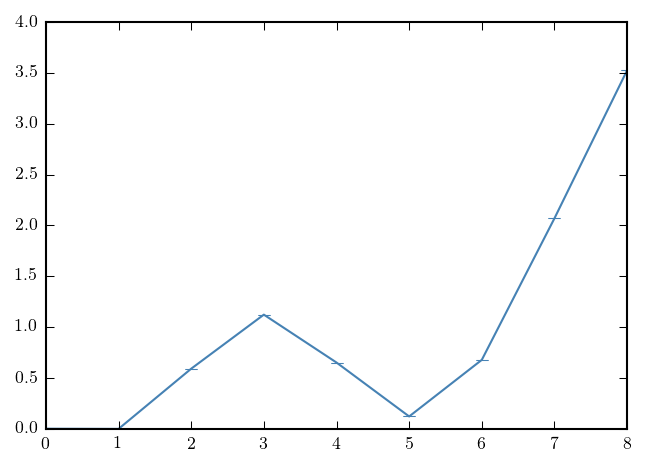

In [21]:
plt.errorbar(range(9),vals, valunc)

In [5]:
import h5py
try:
    modf.close()
except:pass





def WriteHDF5(fname, basedir, tag, m , nrings=9):
    """
    Build the diffuse model according to the best fit parameters and writes model+metadata to an HDF5 file.
    
    :param fname: Output filename for the HDF5 file
    :param basedir: Directory with galprop output files
    :param tag: galprop tag
    :param basedir: iminuit object. 
    :param nrings: number of galprop rings.
    """
    
    X_CO = np.array([m.values['pi0_H2_'+str(i)] for i in range(1,nrings+1)])
    
    #modf = h5py.File(fname, 'w')
    #try:
    # Generate Groups
    template_group = modf.create_group("templates")
    fit_group = modf.create_group("fit_results")


    # Get data dimensions
    tmp = pyfits.open(basedir+'/bremss_healpix_54_'+tag+'.gz')
    energies = tmp[2].data.field(0)
    tShape = (len(energies), tmp[1].data.shape[0])
    print tShape
    del tmp # free memory

    pi0     = template_group.create_dataset("pi0", tShape, dtype='float32')
    pi0_0   = template_group.create_dataset("pi0_0", tShape, dtype='float32')
    brem   = template_group.create_dataset("brem", tShape, dtype='float32')
    brem_0 = template_group.create_dataset("brem_0", tShape, dtype='float32')
    ics_opt = template_group.create_dataset("ics_opt", tShape, dtype='float32')
    ics_fir = template_group.create_dataset("ics_fir", tShape, dtype='float32')
    ics_cmb = template_group.create_dataset("ics_cmb", tShape, dtype='float32')

    # Now fill in the templates one by one.
    # Add fit metadata.
    # Add galdef metadata.


    #---------------------------------------------------------------
    # Create Diffuse Template from fitting results.
    def ReadFits(fname, length):
        d = pyfits.open(fname)[1].data
        return np.array([d.field(i) for i in range(length)])

    for i_ring in range(1,nrings+1):
        print "Adding HI/HII ring", i_ring

        pi0 += ReadFits(basedir+'/pi0_decay_HIR_ring_'+str(i_ring)+'_healpix_54_'+tag+'.gz', len(energies))
        pi0 += ReadFits(basedir+'/pi0_decay_HII_ring_'+str(i_ring)+'_healpix_54_'+tag+'.gz', len(energies))
        pi0 *= m.values['pi0HIHII']
        pi0 += X_CO[i_ring-1]*ReadFits(basedir+'/pi0_decay_H2R_ring_'+str(i_ring)+'_healpix_54_'+tag+'.gz', len(energies))

        brem += ReadFits(basedir+'/bremss_HIR_ring_'+str(i_ring)+'_healpix_54_'+tag+'.gz', len(energies))
        brem += ReadFits(basedir+'/bremss_HII_ring_'+str(i_ring)+'_healpix_54_'+tag+'.gz', len(energies))
        brem *= m.values['pi0HIHII']*1.25
        brem += 1.25*X_CO[i_ring-1]*ReadFits(basedir+'/bremss_H2R_ring_'+str(i_ring)+'_healpix_54_'+tag+'.gz', len(energies))

        if i_ring == 1:
            pi0_0 += pi0
            brem_0 += brem

    ics_opt += m.values['ics']*ReadFits(basedir+'/ics_isotropic_comp_1_healpix_54_'+tag+'.gz', len(energies))
    ics_fir += m.values['ics']*ReadFits(basedir+'/ics_isotropic_comp_2_healpix_54_'+tag+'.gz', len(energies))
    ics_cmb += m.values['ics']*ReadFits(basedir+'/ics_isotropic_comp_3_healpix_54_'+tag+'.gz', len(energies))

#     except:
#         modf.close()
    
    try: 
        modf.close()
    except: pass
    return




modf = h5py.File('test.hdf5', 'w')
WriteHDF5(fname='test.hdf5', basedir='/data/galprop2/output/', tag='base', m=m, nrings=9)








(38, 786432)
Adding HI/HII ring 1
Adding HI/HII ring 2
Adding HI/HII ring 3
Adding HI/HII ring 4
Adding HI/HII ring 5
Adding HI/HII ring 6
Adding HI/HII ring 7
Adding HI/HII ring 8
Adding HI/HII ring 9


In [10]:

def AddMetadata(fname, basedir, tag, A, m):
    # Parse the galprop file into a dict.
    galdef_dict = {}
    with open(basedir + '/galdef_54_'+tag) as galdef:
        for line in galdef: 
            if line[0] != "#" and line.strip()!='':
                s = line.strip('\n').split('=')
                if len(s)<2: 
                    continue
                key = s[0].strip()
                if key in ["Title", 'X_CO_values', 'n_X_CO_values', 'X_CO_radius']: continue
                galdef_dict[key] = s[1].strip().split(" ")[0]
    try: h5.close() 
    except: pass
    h5 = h5py.File(fname, 'a')
    try:
        galdef_group = h5.create_group("galdef")
    except: 
        galdef_group = h5['/galdef']
    for key, val in galdef_dict.items():
        #print key, val
        galdef_group.attrs[key]=val
        
    try:
        fit_results = h5.create_group("/fit_results/global")
    except: 
        fit_results = h5['/fit_results/global']
    
    fit_results.attrs['values'] = m.values.items()
    fit_results.attrs['valuesUnc'] = m.errors.items()
    fit_results.attrs['e_bins'] = A.bin_edges
    fit_results.attrs['irf'] = A.irf
    fit_results.attrs['evclass'] = A.evclass
    fit_results.attrs['convtype'] = A.convtype
    fit_results.create_dataset('mask', data=A.mask.astype(float32))
    fit_results.attrs['phfile'] = A.phfile
    fit_results.attrs['tag'] = A.tag
    h5.close()
    
try:
    modf.close()
except:pass

AddMetadata('test.hdf5',basedir='/data/galprop2/GALDEF/', tag='base', A=A, m=m)




[('pi0HIHII', nan), ('PSC', 1.0), ('pi0_H2_1', nan), ('pi0_H2_9', nan), ('pi0_H2_3', nan), ('pi0_H2_2', nan), ('pi0_H2_5', nan), ('Isotropic', 1.0), ('pi0_H2_7', nan), ('pi0_H2_6', nan), ('ics', nan), ('pi0_H2_8', nan), ('pi0_H2_4', nan)]
